In [3]:
%matplotlib inline
from fastai.vision import *
from fastai import *
from torch.autograd import Variable

import os
import torch
import torchvision
import copy

import torch.nn as nn
import torch.nn.functional as F
os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [4]:
path = Path("/media/subhaditya/DATA/Github/deHazer/data")
path_hr = path / "normal"
path_lr = path / "hazy"

In [5]:
il = ImageList.from_folder(path_hr)

In [6]:
il

ImageList (55 items)
Image (3, 1200, 1600),Image (3, 1200, 1600),Image (3, 1200, 1600),Image (3, 1200, 1600),Image (3, 1200, 1600)
Path: /media/subhaditya/DATA/Github/deHazer/data/normal

In [62]:
def resize_one(fn, i, path, size):
    dest = path / fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert("RGB")
    img.save(dest, quality=60)

In [63]:
sets = [(path_lr, 96), (path_mr, 256)]
for p, size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [7]:
bs, size = 32, 64

In [8]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct()

In [9]:
def get_data(bs, size):
    data = (
        src.label_from_func(lambda x: path_hr / x.name)
        .transform(get_transforms(max_zoom=2.0), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=True)
    )

    #     data.c = 3
    return data

In [10]:
data_gen = get_data(bs, size)

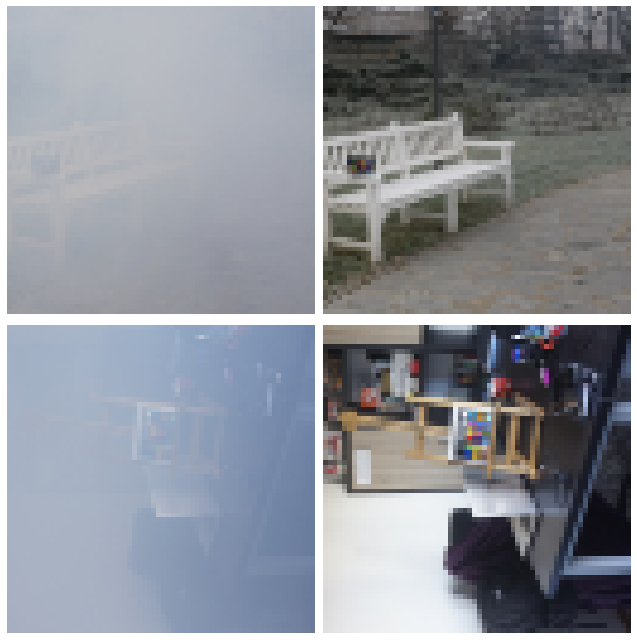

In [11]:
data_gen.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9, 9))

In [16]:
learn = None
gc.collect()

96

In [13]:
def create_loss_model(vgg, end_layer, use_maxpool=True, use_cuda=False):
    """
        [1] uses the output of vgg16 relu2_2 layer as a loss function (layer8 on PyTorch default vgg16 model).
        This function expects a vgg16 model from PyTorch and will return a custom version up until layer = end_layer
        that will be used as our loss function.
    """

    vgg = copy.deepcopy(vgg)

    model = nn.Sequential()

    if use_cuda:
        model.cuda(device_id=0)

    i = 0
    for layer in list(vgg):

        if i > end_layer:
            break

        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            if use_maxpool:
                model.add_module(name, layer)
            else:
                avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)
                model.add_module(name, avgpool)
        i += 1
    return model

In [14]:
class UpsampleBlock(nn.Module):
    """ Upsample block suggested by [2] to remove checkerboard pattern from images """
    def __init__(self, num, use_cuda=False):
        super(UpsampleBlock, self).__init__()
        if use_cuda:
            self.up1 = nn.UpsamplingNearest2d(scale_factor=2).cuda(device_id=0)
            self.c2 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=0).cuda(device_id=0)
            self.b3 = nn.BatchNorm2d(num).cuda(device_id=0)
        else:
            self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
            self.c2 = nn.Conv2d(num, num, kernel_size=3, stride=1, padding=0)
            self.b3 = nn.BatchNorm2d(num)

    def forward(self, x):
        h = self.up1(x)
        h = F.pad(h, (1, 1, 1, 1), mode='reflect')
        h = self.b3(self.c2(h))
        return F.relu(h)

In [15]:
class SuperRes4x(nn.Module):
    def __init__(self, use_cuda=False, use_UpBlock=True):

        super(SuperRes4x, self).__init__()
        # To-do: Retrain with self.uplock and self.use_cuda as parameters

        # self.upblock = use_UpBlock
        # self.use_cuda = use_cuda
        upblock = True

        # Downsizing layer
        if use_cuda:
            self.c1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4).cuda(device_id=0)
            self.b2 = nn.BatchNorm2d(64).cuda(device_id=0)
        else:
            self.c1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
            self.b2 = nn.BatchNorm2d(64)

        if upblock:
            # Loop for residual blocks
            self.rs = [res_block(64) for i in range(4)]
            # Loop for upsampling
            self.up = [UpsampleBlock(64, use_cuda=use_cuda) for i in range(2)]
        else:
            # Loop for residual blocks
            self.rs = [ResidualBlock(64, use_cuda=use_cuda) for i in range(4)]
            # Transposed convolution blocks
            if self.use_cuda:
                self.dc2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1).cuda(device_id=0)
                self.bc2 = nn.BatchNorm2d(64).cuda(device_id=0)
                self.dc3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1).cuda(device_id=0)
                self.bc3 = nn.BatchNorm2d(64).cuda(device_id=0)
            else:
                self.dc2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
                self.bc2 = nn.BatchNorm2d(64)
                self.dc3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
                self.bc3 = nn.BatchNorm2d(64)

        # Last convolutional layer
        if use_cuda:
            self.c3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4).cuda(device_id=0)
        else:
            self.c3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        upblock = True
        # Downsizing layer - Large Kernel ensures large receptive field on the residual blocks
        h = F.relu(self.b2(self.c1(x)))

        # Residual Layers
        for r in self.rs:
            h = r(h)  # will go through all residual blocks in this loop

        if upblock:
            # Upsampling Layers - improvement suggested by [2] to remove "checkerboard pattern"
            for u in self.up:
                h = u(h)  # will go through all upsampling blocks in this loop
        else:
            # As recommended by [1]
            h = F.relu(self.bc2(self.dc2(h)))
            h = F.relu(self.bc3(self.dc3(h)))

        # Last layer and scaled tanh activation - Scaled from 0 to 1 instead of 0 - 255
        h = F.tanh(self.c3(h))
        h = torch.add(h, 1.)
        h = torch.mul(h, 0.5)
        return h

In [17]:
from torchvision import models

In [ ]:
vgg16 = models.vgg16(pretrained=True).features
vgg16.to('cuda')
vgg_loss = create_loss_model(vgg16, 8, use_cuda=use_cuda)

In [12]:
learn = Learner(data_gen, model, wd = 10-4, loss_func= callback_fns=[ShowGraph])

NameError: name 'data' is not defined

In [18]:
learn.fit(1, 1e-6)

epoch,train_loss,valid_loss,time
0,10.948936,8.817058,00:30


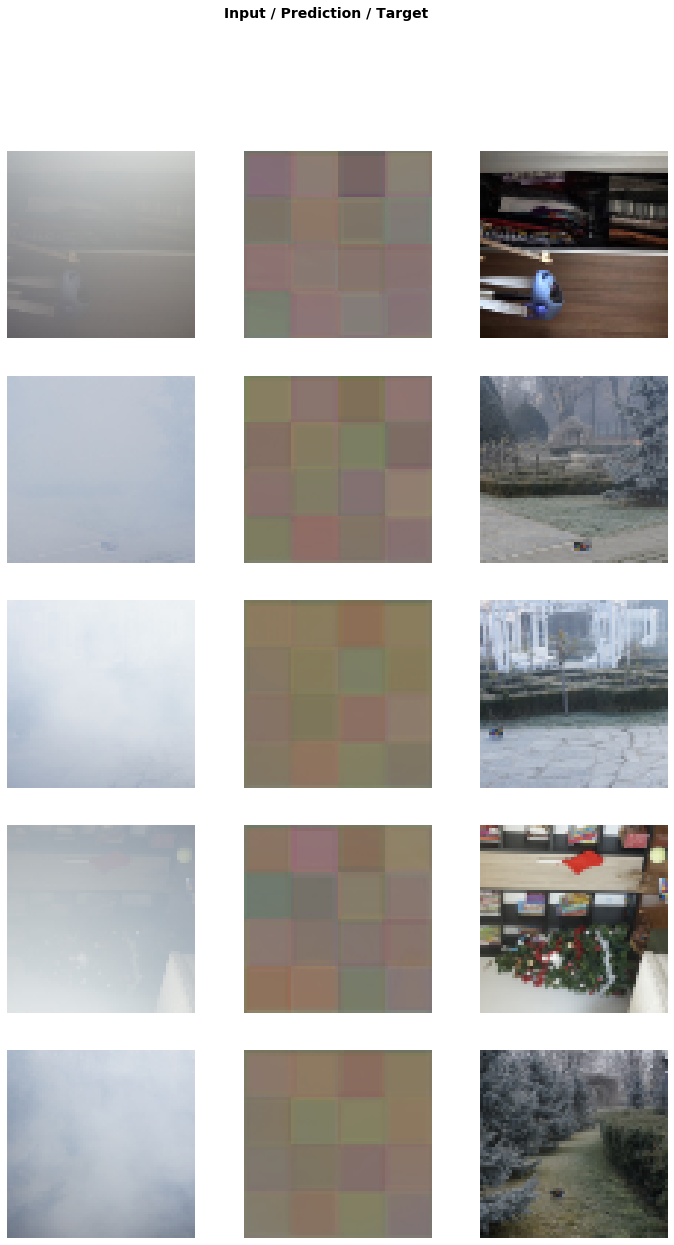

In [19]:
learn.show_results()

In [20]:
learn.unfreeze()
learn.fit(200, 1e-6)

epoch,train_loss,valid_loss,time
0,10.490610,8.819943,00:32
1,10.845919,8.827179,00:33
2,10.735026,8.840517,00:34
3,10.739347,8.862495,00:34
4,10.755848,8.878992,00:33
5,10.740708,8.904608,00:34
6,10.675799,8.930683,00:34
7,10.730921,8.951728,00:34
8,10.742031,8.965336,00:35
9,10.774837,8.940053,00:35


KeyboardInterrupt: 

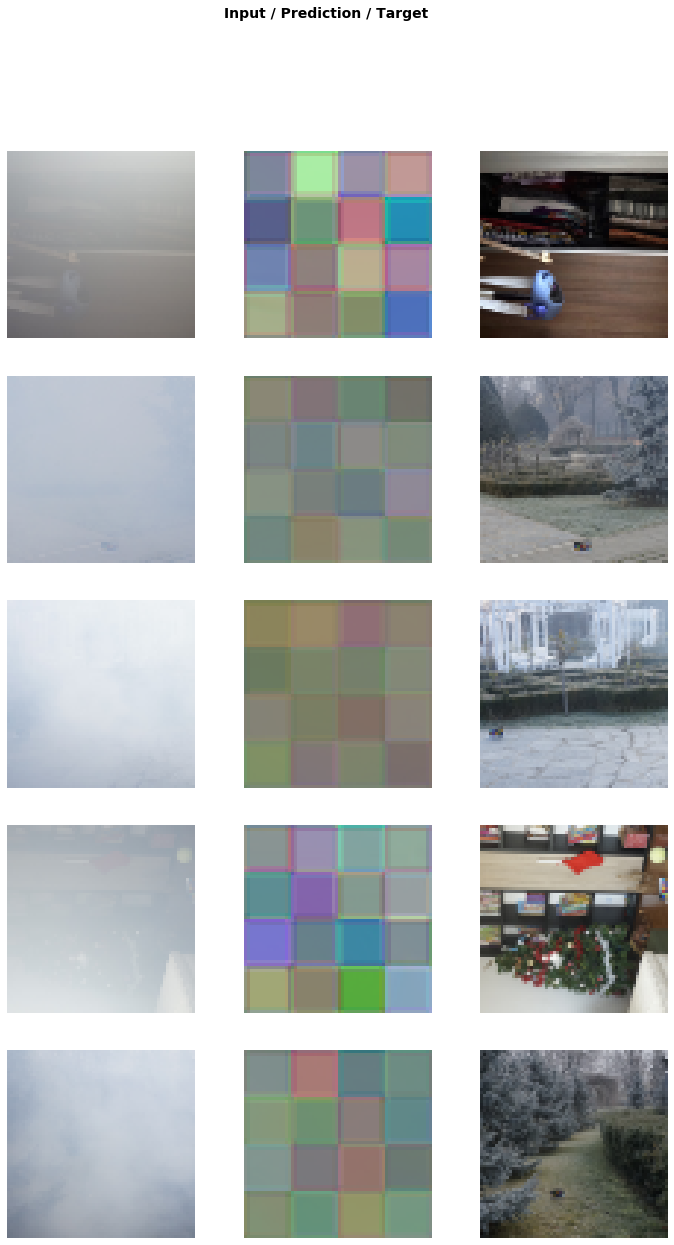

In [21]:
learn.show_results()